# 1. Setup

In [1]:
# Gym stuff
import gym
import gym_anytrading

# Stable baselines - rl stuff
from stable_baselines3.common.vec_env import DummyVecEnv
from stable_baselines3 import A2C, PPO
from stable_baselines3.a2c import MlpPolicy
from stable_baselines3.ppo import MlpPolicy

# Processing libraries
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

# finacial technical analysis
import finta

from sklearn.preprocessing import MinMaxScaler


# calc sma, rsi, obv
# relative strength index - technical traders
# simple moving average
# obv tied to volume

# 2. Bring Marketwatch GME Data
https://www.marketwatch.com/investing/stock/gme/download-data?startDate=11/1/2019&endDate=03/12/2021

In [2]:
# load up dataset for anytrading environment
df = pd.read_csv('data/gmedata.csv')
# change date column to datetime
df['Date'] = pd.to_datetime(df['Date'])
# sort dates so that the oldest date comes first
df.sort_values('Date', ascending=True, inplace=True)
df.set_index('Date',inplace=True)
display(df.head())

,Open,High,Low,Close,Volume
Date,,,,,
2021-12-29,36.96,38.87,35.54,38.48,"8,149,624"
2021-12-30,37.75,40.00,37.50,38.83,"6,247,528"
2021-12-31,38.41,39.18,37.03,37.10,"5,575,856"
2022-01-03,37.31,39.85,37.30,38.21,"5,668,004"
2022-01-04,38.04,38.25,35.76,37.23,"7,339,576"


In [3]:
# setup stocks envirionment
# df is the df passed in
# use first 100 time stamps starting from 10\
# window_size = how many previous timestamps the bot will have before making next prediction
# here you use 95 days of data
window_size = 5
env = gym.make('stocks-v0',df=df,frame_bound=(window_size,100), window_size=window_size)

# 3. Build Environment

In [4]:
# there are 2 actions, buy or sell
env.action_space

Discrete(2)

info {'total_reward': -4.739999999999991, 'total_profit': 0.6838516791238666, 'position': 0}


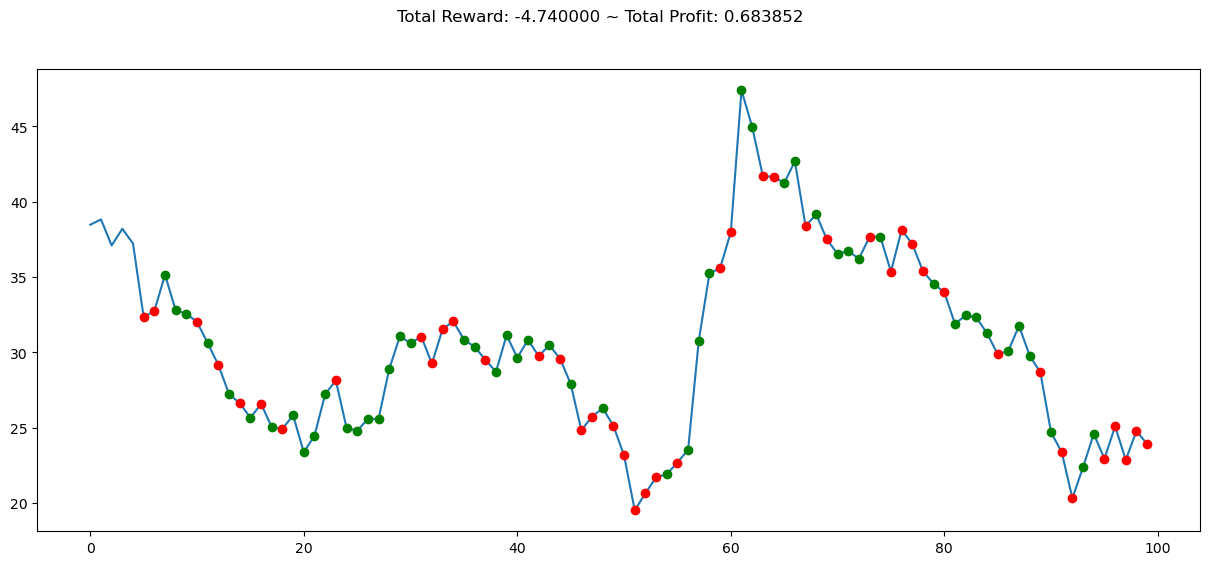

In [5]:
# create test env
state = env.reset()
while True:
    # take a random action from the action space
    # store action in action variable
    action = env.action_space.sample()
    # n_state = what env looks like
    # reward = any money made
    n_state, reward, done, info = env.step(action)
    if done:
        print('info',info)
        break
plt.figure(figsize=(15,6))
plt.cla()
env.render_all()
plt.show()

# 2.1 Add Custom Indicators

## 2.1.1 Import New Dependencies

In [6]:
# custom overlay that allows you to add new indicators
from gym_anytrading.envs import StocksEnv
# technical analysis library
from finta import TA

## 2.1.2 Fix Volume Column

In [7]:
df['Volume'] = df['Volume'].apply(lambda x: float(x.replace(',','')))

## 2.1.3 Calculate SMA, RSI, OBV

In [8]:
df['SMA'] = TA.SMA(df,12)
df['RSI'] = TA.RSI(df)
df['OBV'] = TA.OBV(df)
# lagging values are needed to be able to calculate the above metrics so these will be null
df.fillna(0, inplace=True)

## 2.1.4 Create New Environments

In [9]:
scaler = MinMaxScaler()
scaled = pd.DataFrame(scaler.fit_transform(df))
for i in range(len(df.columns)):
    df[df.columns[i]] = scaled[scaled.columns[i]].values
display(df.head())

,Open,High,Low,Close,Volume,SMA,RSI,OBV
Date,,,,,,,,
2021-12-29,0.647200,0.648977,0.764730,0.697422,0.072236,0.0,0.000000,0.134788
2021-12-30,0.674339,0.685102,0.845488,0.709294,0.052683,0.0,1.000000,0.149209
2021-12-31,0.697011,0.658887,0.826123,0.650611,0.045778,0.0,0.158151,0.136338
2022-01-03,0.659224,0.680307,0.837248,0.688263,0.046726,0.0,0.467755,0.149422
2022-01-04,0.684301,0.629156,0.773795,0.655020,0.063909,0.0,0.346570,0.132480


In [10]:
def add_signals(env):
    # grabs start & end indices
    # env = gym.make( ... frame_bound=(5,100) ... )
    start = env.frame_bound[0] - env.window_size
    end = env.frame_bound[1]
    prices = env.df.loc[:,'Low'].to_numpy()[start:end]
    signal_features = env.df.loc[:, ['Low','Volume','SMA','RSI','OBV']].to_numpy()[start:end]
    return prices, signal_features

In [11]:
# inheritance from StocksEnv
class MyCustomEnv(StocksEnv):
    # native function w/i StocksEnv
    # native function only gives back price and price difference
    _process_data = add_signals
env2 = MyCustomEnv(df=df, window_size = 12, frame_bound = (12,50))

# 4. Build Environment & Trade

In [12]:
# there is a generic env but there are also forex ones
env_maker = lambda: env2
env = DummyVecEnv([env_maker])
# env = gym.make('stocks-v0',df=df,frame_bound=(window_size,100), window_size=window_size)

In [13]:
# A2C is the algorithm
# custom algorithms can be used
# multi layer perceptron lstm policy
    # deep neural network w/ lstm layer
    # lstm layer allows the ai to take into account what it has learned in the previous windows
model = A2C(MlpPolicy,env)
# explained variance should be as high as possible
# callback can be configured w/i learn model to stop learning once a ceratin level of variance is reached
model.learn(total_timesteps=100000)

# 5. Evaluation

info {'total_reward': 0.14462299134734236, 'total_profit': 0.21129782152856313, 'position': 1}


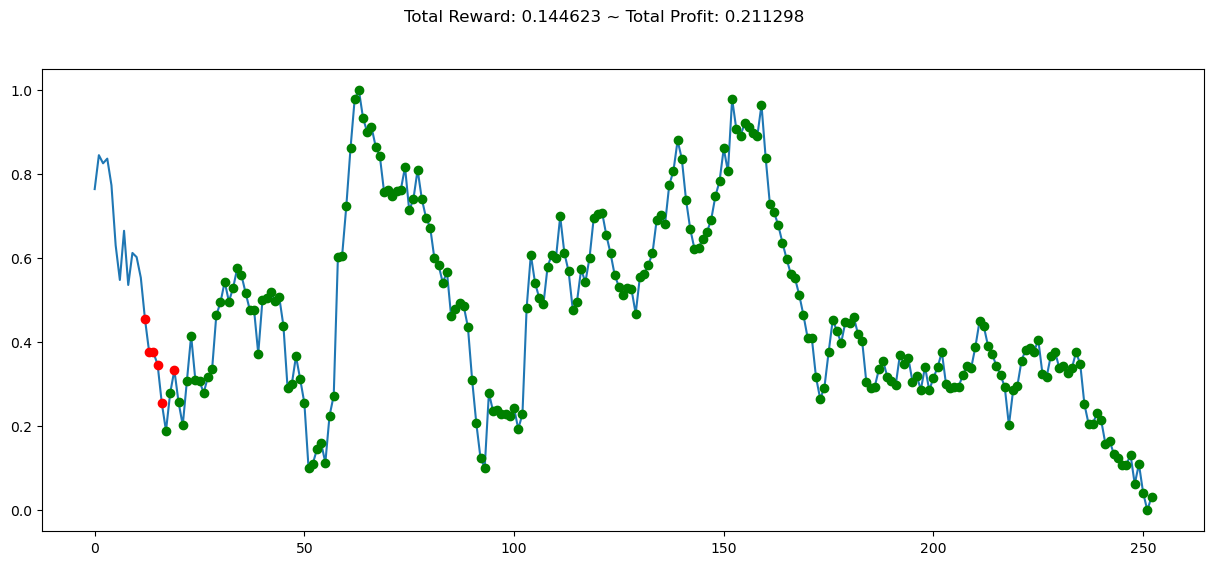

In [14]:
env = MyCustomEnv(df=df, window_size = 12, frame_bound = (12,len(df)))
obs = env.reset()
while True: 
    # reshape observations to work w/i non-vectorized env
    obs = obs[np.newaxis, ...]
    action, _states = model.predict(obs)
    obs, rewards, done, info = env.step(action)
    if done:
        print("info", info)
        break
plt.figure(figsize=(15,6))
plt.cla()
env.render_all()
plt.show()

In [15]:
info.items()

dict_items([('total_reward', 0.14462299134734236), ('total_profit', 0.21129782152856313), ('position', 1)])

In [16]:
## find avg profit & then compare models w/ this all in mind
## train then plot the distribution of the profits & see

In [17]:
## how do i export to tensorboard & allow the model to keep learning on future data that must be added